# Figure 3: polymerization wave in REF52 cells

This jupyter notebook is used to calculate delays of the myosin and rGBD channels with respect to actin.


# Load required packages

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from napari.utils.colormaps import label_colormap
from napari_timestamper import render_as_rgb

import napari

from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median

from napari_timestamper import save_image_stack

from skimage import io
from skimage.filters import gaussian
from skimage.filters import rank
from skimage.measure import regionprops
from skimage.util import map_array

from scipy import ndimage
from scipy import stats
from statsmodels.tsa.tsatools import detrend

from basicpy import BaSiC
from pystackreg import StackReg

from numba import njit, prange, types
from numba.typed import List


from napari.utils.colormaps import CyclicLabelColormap
from matplotlib import colormaps as mpl_colormaps
from matplotlib.ticker import MultipleLocator, FuncFormatter

import cv2

from cellpose import models


from tqdm.auto import tqdm

# Define the row type at the module level
RowType = types.Tuple(
    (
        types.int64,  # event_id
        types.int64,  # frame_offset
        types.int64,  # global_frame
        types.float64,  # intensity_val
        types.int64,  # channel_idx
        types.int64,  # middle_frame
    )
)


# rc config to save svgs as text
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"
# set font size to 8
plt.rcParams.update({"font.size": 8})

In [2]:
colors = ["#046735", "#76CDE8", "#7A2989"]
names = ["actin", "myosin", "rGBD"]

# create a deterministic CyclicColormap for the tracked waves
tab20 = mpl_colormaps.get_cmap("tab20")
colors_tab20 = [color for idx, color in enumerate(tab20.colors) if idx not in [10, 11, 14, 15]]
# create a tab20b cyclic colormap
cmap = CyclicLabelColormap(
    colors_tab20,
    name="tab20b",
    N=16,
    cyclic=True,
)

In [ ]:
DIR_CORE = "4_polymerization_wave" # set this to the directory where the data is stored
DIR_IN = os.path.join(DIR_CORE, "raw")
DIR_OUT_DATA = os.path.join(DIR_CORE, "output-data")
DIR_OUT_PLOT = os.path.join(DIR_CORE, "output-plots")
DIR_OUT_VIDEO = os.path.join(DIR_CORE, "output-videos")
DIR_MISC = "misc"

PIXEL_SIZE = 0.366
SAMPLE_PERIOD_S = 10  # sample period in seconds
WINDOW_SIZE = 100  # window size in frames; set as needed

In [4]:
# create output directories if they do not exist
os.makedirs(DIR_OUT_DATA, exist_ok=True)
os.makedirs(DIR_OUT_PLOT, exist_ok=True)
os.makedirs(DIR_OUT_VIDEO, exist_ok=True)

# Define functions

In [ ]:
def remap_segmentation(
    df: pd.DataFrame,
    segmentation: list,
    timepoint_column: str = "timepoint",
    label_column: str = "label",
    measure_column: str = "ERK",
) -> list:
    tracked_numpy = df[[timepoint_column, label_column, measure_column]].sort_values(timepoint_column).to_numpy()
    grouped_numpy = np.split(tracked_numpy, np.unique(tracked_numpy[:, 0], return_index=True)[1][1:])
    ratio_remapped = []
    for img, grp in zip(segmentation, grouped_numpy):
        img_copy = map_array(img, grp[:, 1], grp[:, 2])
        ratio_remapped.append(img_copy)
    return np.asarray(ratio_remapped)


def compute_confidence_interval(data, confidence_level=0.95):
    """
    Compute the confidence interval for the given data.

    Parameters:
    - data (array-like): The data for which to compute the confidence interval.
    - confidence_level (float): The confidence level for the interval (default is 0.95).

    Returns:
    - tuple: The mean and the confidence interval as (mean, (lower_bound, upper_bound)).
    """
    mean = np.mean(data)
    sem = stats.sem(data)
    degrees_of_freedom = len(data) - 1
    t_score = stats.t.ppf((1 + confidence_level) / 2.0, degrees_of_freedom)
    margin_of_error = t_score * sem
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return mean, confidence_interval


def match_histogram(source, template):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=65536, range=(0, 65536))
    hist_template, _ = np.histogram(template.ravel(), bins=65536, range=(0, 65536))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(65536, dtype=np.uint16)
    j = 0
    for i in range(65536):
        while cdf_template[j] < cdf_source[i] and j < 65535:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched


def match_histogram_stack(img_stack, template):
    matched_stack = np.zeros_like(img_stack)
    for i in range(img_stack.shape[0]):
        matched_stack[i] = match_histogram(img_stack[i], template)
    return matched_stack


def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def correct_flatfield(raw_image: np.ndarray, flatfield_image: np.ndarray, darkfield_image: np.ndarray) -> np.ndarray:
    """
    Corrects flatfield in a microscopy image using dark field correction and gain.

    see wiki: https://en.wikipedia.org/wiki/Flat-field_correction

    Arguments
    ---------
        raw_image (np.ndarray): numpy array, the raw image to correct
        flatfield_image (np.ndarray): numpy array, the flatfield image
        darkfield_image (np.ndarray): numpy array, the darkfield image

    Returns
    -------
        np.ndarray: Corrected image.
    """
    # Ensure the images are in float format to avoid division issues
    raw_image = raw_image.astype(np.float32)
    flatfield_image = flatfield_image.astype(np.float32)
    darkfield_image = darkfield_image.astype(np.float32)

    # Calculate the image-averaged value of (F - D)
    m = np.mean(flatfield_image - darkfield_image)

    # Calculate the gain
    gain = m / (flatfield_image - darkfield_image)

    # Apply the correction formula: C = (R - D) * G
    corrected_image = (raw_image - darkfield_image) * gain

    return corrected_image


def correct_flatfield_stack(stack, flatfield, darkfield):
    corrected_stack = np.zeros_like(stack)
    for i in range(stack.shape[0]):
        corrected_stack[i] = correct_flatfield(stack[i], flatfield, darkfield)
    return corrected_stack


def post_process_results(results_list, intensity_column: str = "normalized_intensity", filter_window_size: int = 9):
    """
    Convert results to a Pandas DataFrame and normalize intensities by event_id.
    """
    # Convert to DataFrame
    df = pd.DataFrame(
        results_list, columns=["event_id", "window_frame", "frame", "intensity", "channel_idx", "middle_frame"]
    )

    df["channel"] = df["channel_idx"].map({0: "intensity_mean-0", 1: "intensity_mean-1", 2: "intensity_mean-2"})

    # Apply median filter using rolling within each group, ensuring alignment
    df["filtered_intensity"] = df.groupby(["event_id", "channel", "middle_frame"])["intensity"].transform(
        lambda x: x.rolling(window=filter_window_size, min_periods=1, center=True).median()
    )

    # Normalize intensities
    df["normalized_intensity"] = df.groupby(["event_id", "channel", "middle_frame"])["filtered_intensity"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Detrend intensities
    df["detrended_intensities"] = df.groupby(["event_id", "channel", "middle_frame"])["normalized_intensity"].transform(
        lambda x: detrend(x, order=1)
    )

    # Reshape DataFrame: one column per channel
    df = df.pivot_table(
        index=["event_id", "window_frame", "frame", "middle_frame"], columns="channel", values=intensity_column
    ).reset_index()

    return df


@njit
def get_event_properties(event_image, event_id):
    """
    Identify the start and end frames of an event and its duration.
    """
    filtered_event = (event_image == event_id).astype(np.uint8)
    num_frames = filtered_event.shape[0]
    start_frame = -1
    end_frame = -1
    count = 0

    for i in range(num_frames):
        if np.any(filtered_event[i]):
            if count == 0:
                start_frame = i
            end_frame = i
            count += 1

    if count == 0:
        return -1, -1, 0, filtered_event

    duration = end_frame - start_frame + 1
    return start_frame, end_frame, duration, filtered_event


@njit
def compute_label_intensities(
    filtered_event,
    intensity_image,
    start_frame,
    end_frame,
    num_channels,
    window_size=100,
    padding_mode="edge",
    valid_windows_only=False,
):
    """
    Compute mean intensities for a window around each middle frame.
    """
    n_frames = filtered_event.shape[0]
    # If only valid windows are allowed, restrict the middle frames range.
    if valid_windows_only:
        valid_start = max(start_frame, window_size)
        valid_end = min(end_frame, n_frames - window_size)
        valid_middle_frames = []
        for m in range(valid_start, valid_end):
            valid_middle_frames.append(m)
    else:
        valid_middle_frames = []
        for m in range(start_frame, end_frame):
            valid_middle_frames.append(m)

    num_valid = len(valid_middle_frames)
    intensities = np.zeros((window_size * 2, num_valid, num_channels))

    for idx in range(num_valid):
        m = valid_middle_frames[idx]
        min_frame_range = m - window_size
        max_frame_range = m + window_size
        label_image = filtered_event[m]

        # Precompute the indices for the mask once per middle frame.
        nrows, ncols = label_image.shape
        count_pixels = 0
        for i in range(nrows):
            for j in range(ncols):
                if label_image[i, j]:
                    count_pixels += 1
        indices_i = np.empty(count_pixels, dtype=np.int64)
        indices_j = np.empty(count_pixels, dtype=np.int64)
        k = 0
        for i in range(nrows):
            for j in range(ncols):
                if label_image[i, j]:
                    indices_i[k] = i
                    indices_j[k] = j
                    k += 1

        # Process each frame in the window
        for frame in range(min_frame_range, max_frame_range):
            # Determine which frame to use (with padding)
            if frame < 0:
                if padding_mode == "nan":
                    channel_data = np.full((intensity_image.shape[1], intensity_image.shape[2], num_channels), np.nan)
                else:  # "edge"
                    channel_data = intensity_image[0]
            elif frame >= intensity_image.shape[0]:
                if padding_mode == "nan":
                    channel_data = np.full((intensity_image.shape[1], intensity_image.shape[2], num_channels), np.nan)
                else:
                    channel_data = intensity_image[-1]
            else:
                channel_data = intensity_image[frame]
            frame_offset = frame - min_frame_range

            # For each channel, compute the mean of the masked pixels.
            for ch in range(num_channels):
                sum_val = 0.0
                cnt = 0
                for k in range(count_pixels):
                    val = channel_data[indices_i[k], indices_j[k], ch]
                    # For 'nan' mode, skip NaNs in the average.
                    if padding_mode == "nan" and np.isnan(val):
                        continue
                    sum_val += val
                    cnt += 1
                if cnt > 0:
                    intensities[frame_offset, idx, ch] = sum_val / cnt
                else:
                    intensities[frame_offset, idx, ch] = np.nan

    return intensities, valid_middle_frames


@njit(parallel=True)
def analyze_events(
    event_image,
    intensity_image,
    event_ids,
    window_size,
    padding_mode="edge",
    valid_windows_only=False,
    min_duration=10,
):
    """
    Analyze events in an event image and compute intensities for each event.

    Parameters:
    - event_image (np.ndarray): The event image.
    - intensity_image (np.ndarray): The intensity image array, with shape (n_frames, height, width, n_channels).
    - event_ids (list): The list of event IDs to analyze.
    - window_size (int): The window size for computing intensities.
    - padding_mode (str): The padding mode for frames outside the intensity image. Can be 'edge' or 'nan'. Only required
        if valid_windows_only is False.
    - valid_windows_only (bool): If True, only valid windows are considered. Where a valid window is one that does not
        extend beyond the start or end of the event.
    - min_duration (int): The minimum duration of an event to consider.
    """
    num_events = len(event_ids)
    num_channels = intensity_image.shape[-1]

    # We can't safely append to one shared list in parallel
    # Instead, keep a separate list per event, then merge them
    num_events = len(event_ids)
    partial_results = [List.empty_list(RowType) for _ in range(num_events)]

    for i in prange(len(event_ids)):
        local_list = List.empty_list(RowType)
        event_id = event_ids[i]
        start_frame, end_frame, duration, filtered_event = get_event_properties(event_image, event_id)
        if duration < min_duration:
            partial_results[i] = local_list  # just store empty
            continue
        intensities, valid_middle_frames = compute_label_intensities(
            filtered_event,
            intensity_image,
            start_frame,
            end_frame,
            num_channels,
            window_size,
            padding_mode,
            valid_windows_only,
        )
        for mid_idx in range(len(valid_middle_frames)):
            m = valid_middle_frames[mid_idx]
            for frame_offset in range(intensities.shape[0]):
                global_frame = (m - window_size) + frame_offset
                for ch in range(num_channels):
                    val = intensities[frame_offset, mid_idx, ch]
                    # make sure everything is cast to int64 or float64
                    local_list.append(
                        (
                            np.int64(event_id),
                            np.int64(frame_offset),
                            np.int64(global_frame),
                            np.float64(val),
                            np.int64(ch),
                            np.int64(m),
                        )
                    )

        partial_results[i] = local_list

    # Merge partial results in a single list after the parallel loop
    combined = List.empty_list(RowType)
    for i in range(num_events):
        for row in partial_results[i]:
            combined.append(row)

    return combined


def stackreg_progress_callback(current_iteration, end_iteration):
    progress = current_iteration / end_iteration * 100

    if progress < 100:
        print(" " * 100, end="\r")
    print(f"StackReg: {progress:.2f}% complete", end="\r")

# Load the raw data

In [6]:
raw_data_lifeact_myosin_rgbd = io.imread(os.path.join(DIR_IN, "LA_mNeonGreen_MLC_miRFP703_2x_rGBD_dTomato_TIRF.tiff"))

# Preprocess the Images

#### Extract the individual channels and perform histogram matching to account for photobleaching

In [7]:
myosin_bl = []
rGBD_bl = []
actin_bl = []

# extract the individual channels
myosin = raw_data_lifeact_myosin_rgbd[..., 1]
rGBD = raw_data_lifeact_myosin_rgbd[..., 2]
actin = raw_data_lifeact_myosin_rgbd[..., 0]

# use first frame as reference for histogram matching
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]

# perform histogram matching
myosin_bl.append(np.stack([match_histogram(img, reference_myosin) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin) for img in tqdm(actin)]))
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

#### Perform image registration

In [8]:
sr = StackReg(StackReg.RIGID_BODY)

tmats = sr.register_stack(actin_bl, reference="previous", progress_callback=stackreg_progress_callback)
# transform using the same transformation matrix as for actin
actin_reg = sr.transform_stack(actin_bl)
myosin_reg = sr.transform_stack(myosin_bl)
rGBD_reg = sr.transform_stack(rGBD_bl)

#### Perform Flatfield Correction

In [9]:
basic_myosin = BaSiC(smoothness_flatfield=5, max_workers=8)
basic_myosin.fit(myosin_reg[:30])

basic_rGBD = BaSiC(smoothness_flatfield=5, max_workers=8)
basic_rGBD.fit(rGBD_reg[:30])

basic_actin = BaSiC(smoothness_flatfield=5, max_workers=8)
basic_actin.fit(actin_reg[:30])

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


#### Show estimated flatfield image

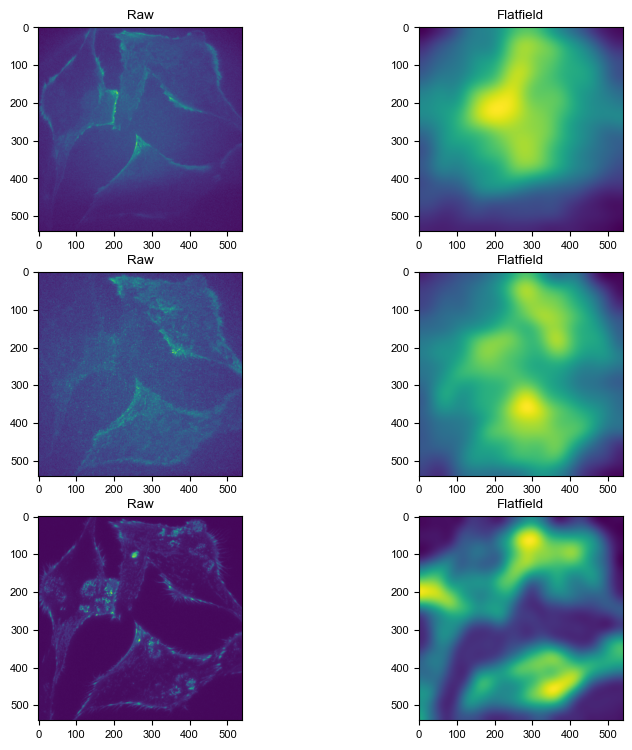

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(9, 9))
for ax, img, b in zip(axes, [myosin_bl, rGBD_bl, actin_bl], [basic_myosin, basic_rGBD, basic_actin]):
    ax[0].set_title("Raw")
    ax[0].imshow(img[0])
    ax[1].set_title("Flatfield")
    ax[1].imshow(b.flatfield)

#### Apply correction and show corrected image

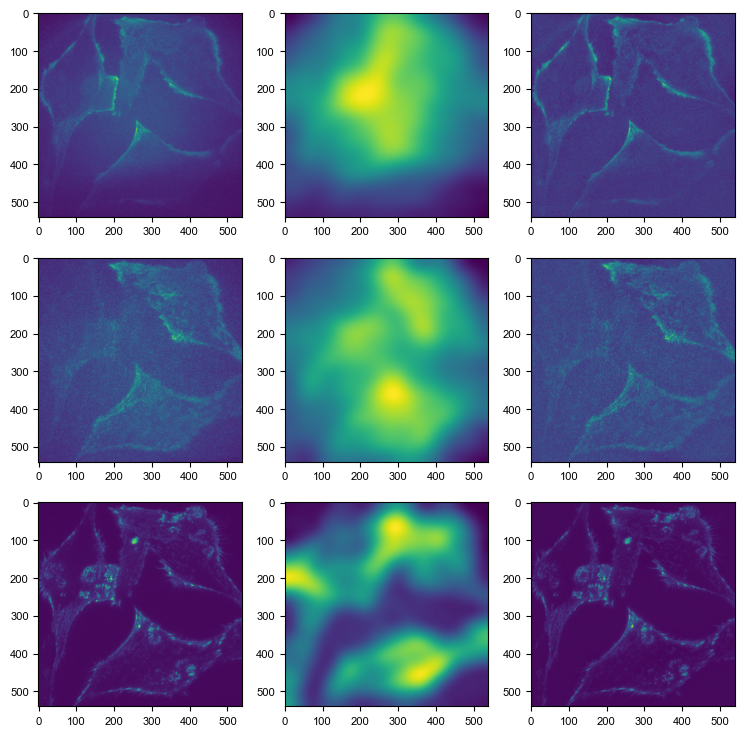

In [11]:
ff_filtered_myosin = ndimage.gaussian_filter(basic_myosin.flatfield, 10)
ff_filtered_rGBD = ndimage.gaussian_filter(basic_rGBD.flatfield, 10)
ff_filtered_actin = ndimage.gaussian_filter(basic_actin.flatfield, 10)

myosin_corrected = correct_flatfield(myosin_reg[0], ff_filtered_myosin, basic_myosin.darkfield)
rGBD_corrected = correct_flatfield(rGBD_reg[0], ff_filtered_rGBD, basic_rGBD.darkfield)
actin_corrected = correct_flatfield(actin_reg[0], ff_filtered_actin, basic_actin.darkfield)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, ori, ff, ori_corr in zip(
    axes,
    [myosin[0], rGBD[0], actin[0]],
    [ff_filtered_myosin, ff_filtered_rGBD, ff_filtered_actin],
    [myosin_corrected, rGBD_corrected, actin_corrected],
):
    ax[0].imshow(ori)
    ax[1].imshow(ff)
    ax[2].imshow(ori_corr)

In [12]:
# apply flatfield correction to the entire stack
myosin_corrected = correct_flatfield_stack(myosin_reg, ff_filtered_myosin, basic_myosin.darkfield)
rGBD_corrected = correct_flatfield_stack(rGBD_reg, ff_filtered_rGBD, basic_rGBD.darkfield)
actin_corrected = correct_flatfield_stack(actin_reg, ff_filtered_actin, basic_actin.darkfield)

In [13]:
binned_actin = blockwise_median(actin_corrected, (1, 2, 2))
binned_actin_alot = blockwise_median(actin_corrected, (1, 2, 2))

#### Segment Cells with Cellpose

In [ ]:
all_masks = []

model = models.CellposeModel(gpu=True, pretrained_model=os.path.join(DIR_MISC, "CP_20250220_183443"))
for idx, i in tqdm(enumerate(actin_corrected), total=len(actin_corrected)):
    masks = model.eval(i, channels=[0, 0])[0]
    all_masks.append(masks)

io.imsave(
    os.path.join(DIR_IN, "cellpose_segmentation.tiff"), np.stack(all_masks), check_contrast=False, compression="zlib"
)

#### Remove the background from the actin channel 

In [15]:
actin_bg = remove_image_background(binned_actin, size=(100, 1, 1), filter_type="median", crop_time_axis=True)
actin_bg = np.where(actin_bg < 0, 0, actin_bg)

#### Perform Gaussian filtering on the background-subtracted actin channel to remove noise

In [16]:
filtered_actin_bg = gaussian(actin_bg, sigma=2)

#### Remove Edge Artifacts from the filtered image as we dont want to track those

In [17]:
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize

# upscale the mask
masks = io.imread(os.path.join(DIR_IN, "cellpose_segmentation.tiff"))
rescaled = resize(np.stack(masks)[50:-50], actin_bg.shape, order=0)
# apply distance transfomration to the mask
distance_transform = distance_transform_edt(rescaled)
# remove everything but the edge of the mask
edge_mask = np.where(distance_transform > 5, 1, 0)
# apply the edge mask to the background subtracted actin image
actin_bg_edge = filtered_actin_bg * edge_mask

# Track Actin Waves

In [18]:
tracked_waves, lineage = track_events_image(
    actin_bg_edge > 25,
    min_clustersize=9,
    eps=1.5,
    eps_prev=1,
    predictor=True,
    n_prev=3,
    downsample=1,
    remove_small_clusters=True,
    allow_merges=True,
    allow_splits=True,
    stability_threshold=6,
    clustering_method="dbscan",
)

100%|██████████| 621/621 [00:19<00:00, 32.07it/s]


#### Create Events remapped to lineages and generate annotated RGB stack

In [19]:
all_lineages_data = []

data = []
lineage_filtered = lineage.filter("lineage_duration", 3)
events_filtered = lineage_filtered.reflect(tracked_waves)
# Traverse nodes and aggregate lineage_id and event_id
for node in lineage_filtered.nodes.values():
    lid = node.lineage_id
    event_id = node.cluster_id
    data.append(
        {
            "lineage_id": lid,
            "event_id": event_id,
        }
    )

lineages_df = pd.DataFrame(data)

data = []
# create a lineage/label df
for i, frame_data in enumerate(events_filtered):
    for event in regionprops(frame_data):
        if event.label == 0:
            continue
        data.append(
            {
                "timepoint": i,
                "event": event.label,
                "lineage": lineage_filtered.nodes[event.label].lineage_id,
                "x": event.centroid[1],
                "y": event.centroid[0],
                "bbox-0": event.bbox[0],
                "bbox-1": event.bbox[1],
                "bbox-2": event.bbox[2],
                "bbox-3": event.bbox[3],
            }
        )

lineage_df = pd.DataFrame(data)

# remap the segmentation
events_lineage = remap_segmentation(
    lineage_df, events_filtered, timepoint_column="timepoint", label_column="event", measure_column="lineage"
)

In [20]:
viewer = napari.Viewer()

viewer.add_image(
    binned_actin[50:-50],
    name="binned_actin",
    colormap="gray_r",
    contrast_limits=[binned_actin.min() * 1.1, binned_actin.max() * 0.5],
)
lineage_id_layer = viewer.add_labels(events_lineage, name="lineages", colormap=cmap)

lineage_id_layer.new_colormap(seed=0)
lineage_id_layer.contour = 2
lineage_id_layer.opacity = 1
rgb_stack = render_as_rgb(viewer, 0, 4)

# hide the lineage layer and render the lifeact image alone
lineage_id_layer.visible = False
rgb_lifeact = render_as_rgb(viewer, 0, 4)
viewer.close()

In [21]:
alpha_box = 0.5  # Transparency for bounding box
alpha_label = 0.5  # Transparency for label background
outline_color = (255, 255, 255)  # White outline
label_bg_color = (255, 255, 255)  # White background for label
text_color = (0, 0, 0, 255)  # Black text
annotated_stack = rgb_stack.copy()

for i, frame in enumerate(annotated_stack):
    lineage_df_frame = lineage_df[lineage_df["timepoint"] == i]

    overlay = frame.copy()

    for _, row in lineage_df_frame.iterrows():
        minr = int(row["bbox-0"])
        minc = int(row["bbox-1"])
        maxr = int(row["bbox-2"])
        maxc = int(row["bbox-3"])

        # Scale due to upsampling
        scale = 4
        minr, minc, maxr, maxc = (val * scale for val in (minr, minc, maxr, maxc))

        x_min, y_min = minc, minr
        x_max, y_max = maxc, maxr

        cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), outline_color, thickness=2)

        label = f"ID:{row['event']:.0f}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        text_thickness = 2

        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, text_thickness)
        label_height = text_height + baseline

        label_x1 = x_min
        label_y2 = y_min
        label_x2 = x_min + text_width
        label_y1 = label_y2 - label_height

        label_y1 = max(label_y1, 0)

        cv2.rectangle(overlay, (label_x1, label_y1), (label_x2, label_y2), label_bg_color, -1)

    cv2.addWeighted(overlay, alpha_box, frame, 1 - alpha_box, 0, frame)

    for _, row in lineage_df_frame.iterrows():
        label = f"ID:{row['event']:.0f}"
        font_scale = 0.7
        text_thickness = 1

        minr = int(row["bbox-0"])
        minc = int(row["bbox-1"])
        maxr = int(row["bbox-2"])
        maxc = int(row["bbox-3"])
        scale = 4
        minr, minc, maxr, maxc = (val * scale for val in (minr, minc, maxr, maxc))

        x_min, y_min = minc, minr

        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, text_thickness)
        label_height = text_height + baseline
        label_x1 = x_min
        label_y2 = y_min
        label_x2 = x_min + text_width
        label_y1 = label_y2 - label_height
        label_y1 = max(label_y1, 0)

        text_x = label_x1
        text_y = label_y2 - baseline

        cv2.putText(
            frame,
            label,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            text_thickness,
            cv2.LINE_AA,
        )

In [22]:
events_upscaled = []
for t in events_filtered:
    t_img = upscale_image(t, 2)
    events_upscaled.append(t_img)
events_upscaled = np.stack(events_upscaled)

events_lineage_upscaled = []
for t in events_lineage:
    t_img = upscale_image(t, 2)
    events_lineage_upscaled.append(t_img)
events_lineage_upscaled = np.stack(events_lineage_upscaled)

In [23]:
viewer = napari.Viewer()

viewer.add_image(actin_corrected[50:-50], name="actin", colormap="gray_r")
viewer.add_labels(events_upscaled, name="events_upscaled")
viewer.add_labels(events_lineage_upscaled, name="lineages_upscaled", colormap=cmap)

<Labels layer 'lineages_upscaled' at 0x2abf1cc0110>

#### Save intermediate Data

In [24]:
io.imsave(os.path.join(DIR_OUT_DATA, "actin_corrected.tif"), actin_corrected)
io.imsave(os.path.join(DIR_OUT_DATA, "myosin_corrected.tif"), myosin_corrected)
io.imsave(os.path.join(DIR_OUT_DATA, "rGBD_corrected.tif"), rGBD_corrected)
io.imsave(os.path.join(DIR_OUT_DATA, "tracked_waves.tif"), events_upscaled)
io.imsave(os.path.join(DIR_OUT_DATA, "tracked_waves_rgb.tif"), annotated_stack)
io.imsave(os.path.join(DIR_OUT_DATA, "lifeact_rgb.tif"), rgb_lifeact)

c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: C:/Users/benig/Downloads/S-BIAD1683(1)/4_polymerization_wave\output-data\tracked_waves.tif is a low contrast image
  return func(*args, **kwargs)


# Extract windowed intensity values for all channels

In [25]:
# load the data using os.path.join
actin_corrected = io.imread(os.path.join(DIR_OUT_DATA, "actin_corrected.tif"))
myosin_corrected = io.imread(os.path.join(DIR_OUT_DATA, "myosin_corrected.tif"))
rGBD_corrected = io.imread(os.path.join(DIR_OUT_DATA, "rGBD_corrected.tif"))
events_upscaled = io.imread(os.path.join(DIR_OUT_DATA, "tracked_waves.tif"))

In [26]:
viewer = napari.Viewer()

viewer.add_image(actin_corrected[50:-50], name="actin", scale=(1, PIXEL_SIZE, PIXEL_SIZE))
viewer.add_image(myosin_corrected[50:-50], name="myosin", scale=(1, PIXEL_SIZE, PIXEL_SIZE))
viewer.add_image(rGBD_corrected[50:-50], name="rGBD", scale=(1, PIXEL_SIZE, PIXEL_SIZE))
viewer.add_labels(events_upscaled, name="events_upscaled", scale=(1, PIXEL_SIZE, PIXEL_SIZE))

<Labels layer 'events_upscaled' at 0x2aa9c2778f0>

In [27]:
event_ids = np.unique(events_upscaled)[1:]  # Assuming 0 is background

# Run the analysis
results_list = analyze_events(
    event_image=events_upscaled.astype(float),
    intensity_image=np.stack([actin_corrected, myosin_corrected, rGBD_corrected], axis=-1, dtype=float)[50:-50],
    event_ids=event_ids,
    window_size=WINDOW_SIZE,
    min_duration=20,
    valid_windows_only=True,
)

In [28]:
# Post-process the results, smooths, normalizes and detrends the intensities
df = post_process_results(results_list, "detrended_intensities", filter_window_size=9)
print("Number of events analyzed:", len(df["event_id"].unique()))
print("Number of unique windows analyzed:", df.groupby(["event_id", "middle_frame"]).ngroups)
df.head()

Number of events analyzed: 175
Number of unique windows analyzed: 5462


channel,event_id,window_frame,frame,middle_frame,intensity_mean-0,intensity_mean-1,intensity_mean-2
0,64,0,0,100,0.347408,0.257820,0.119333
1,64,0,1,101,0.372664,0.361703,0.096616
2,64,0,2,102,0.322517,0.461613,-0.106863
3,64,0,3,103,0.411697,0.327842,-0.411386
4,64,0,4,104,0.431021,0.242491,-0.433461


## Plot Results

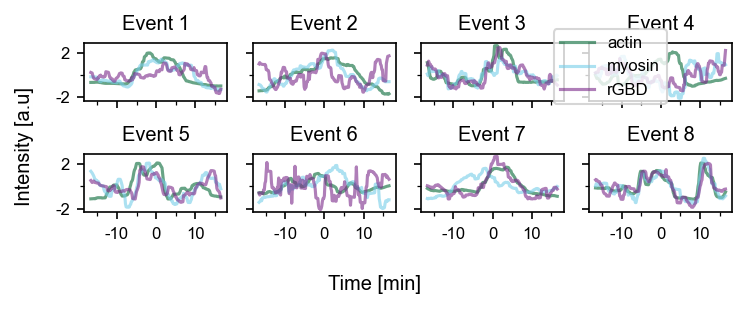

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

names = ["actin", "myosin", "rGBD"]
colors = ["#046735", "#76CDE8", "#7A2989"]

# Sample a random set of rows from the DataFrame
unique_combinations = df["event_id"].drop_duplicates().sample(n=8, random_state=0)

# Create a 2x4 grid of plots
fig, axes = plt.subplots(2, 4, figsize=(5, 2), sharex=True, sharey=True, dpi=150)
axes = axes.flatten()

for i, (ax, row) in enumerate(zip(axes, unique_combinations)):
    # Filter the original DataFrame for the current combination
    grp = df[df["event_id"] == row]
    grp = grp[grp["middle_frame"] == grp["middle_frame"].sample(1, random_state=0).iloc[0]]

    # Convert frames to minutes (already done inline)
    time_in_minutes = (grp["window_frame"] - WINDOW_SIZE) * SAMPLE_PERIOD_S / 60

    # Plot each channel
    ax.plot(time_in_minutes, grp["intensity_mean-0"], color=colors[0], alpha=0.6, label=names[0])
    ax.plot(time_in_minutes, grp["intensity_mean-1"], color=colors[1], alpha=0.6, label=names[1])
    ax.plot(time_in_minutes, grp["intensity_mean-2"], color=colors[2], alpha=0.6, label=names[2])

    ax.set_title(f"Event: {row}", fontsize=8)

# Apply integer-minute ticks on the shared x-axis
for idx, ax in enumerate(axes):
    ax.set_title(f"Event {idx + 1}")
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.yaxis.set_major_locator(MultipleLocator(4, -2))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.yaxis.set_minor_locator(MultipleLocator(4))


fig.supylabel("Intensity [a.u]")
fig.supxlabel("Time [min]")
fig.legend(labels=names, loc="upper right", bbox_to_anchor=(0.9, 0.92))

plt.tight_layout()
plt.savefig(os.path.join(DIR_OUT_PLOT, "sample_event.svg"))
plt.show()

Delay of Actin peak relative to Actin (or 0): 0.00 min
Delay of Myosin peak relative to Actin (or 0): 1.00 min
Delay of rGBD peak relative to Actin (or 0): 1.00 min


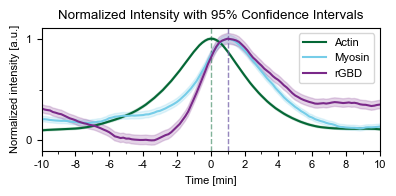

In [ ]:
# Calculate mean, std, and SEM for each frame count
channels = ["intensity_mean-0", "intensity_mean-1", "intensity_mean-2"]
df_summary = df.groupby("window_frame")[channels].agg(["mean", "std", "count"]).reset_index()

# Flatten the multi-level columns
df_summary.columns = ["window_frame"] + [f"{col[0]}_{col[1]}" for col in df_summary.columns[1:]]

# Min-max scale the means and calculate 95% CI
for channel in channels:
    mean_col = f"{channel}_mean"
    std_col = f"{channel}_std"
    count_col = f"{channel}_count"

    # Scale the mean to have a min of 0 and max of 1
    min_val = df_summary[mean_col].min()
    max_val = df_summary[mean_col].max()
    df_summary[mean_col] = (df_summary[mean_col] - min_val) / (max_val - min_val)

    # Adjust std (error bars) based on the same scaling
    scale_factor = 1 / (max_val - min_val)
    df_summary[std_col] = df_summary[std_col] * scale_factor

    # Compute SEM and 95% CI
    df_summary[f"{channel}_sem"] = df_summary[std_col] / np.sqrt(df_summary[count_col])
    df_summary[f"{channel}_ci"] = df_summary[f"{channel}_sem"] * 1.96  # 95% CI

# Convert back to long format for plotting
long_df = pd.melt(
    df_summary,
    id_vars="window_frame",
    value_vars=[f"{channel}_mean" for channel in channels],
    var_name="Channel",
    value_name="Mean_intensity",
)

long_df["centered_frames"] = long_df["window_frame"] - WINDOW_SIZE
long_df["time_in_min"] = long_df["centered_frames"] * (SAMPLE_PERIOD_S / 60)
long_df["time_in_min"] = long_df["time_in_min"].round(2)

# Add confidence intervals
long_df["CI"] = pd.melt(
    df_summary, id_vars="window_frame", value_vars=[f"{channel}_ci" for channel in channels], value_name="CI"
)["CI"]

# Map channel names for better readability
channel_mapping = {"intensity_mean-0_mean": "Actin", "intensity_mean-1_mean": "Myosin", "intensity_mean-2_mean": "rGBD"}
long_df["Channel"] = long_df["Channel"].map(channel_mapping)

# Plotting with confidence intervals
fig, ax = plt.subplots(figsize=(4, 2))

for channel_index, channel in enumerate(long_df["Channel"].unique()):
    subset = long_df[long_df["Channel"] == channel]
    sns.lineplot(
        data=subset,
        x="time_in_min",
        y="Mean_intensity",
        label=channel,
        ax=ax,
        color=colors[channel_index],
        errorbar=None,
    )
    # Confidence intervals
    ax.fill_between(
        subset["time_in_min"],
        subset["Mean_intensity"] - subset["CI"],
        subset["Mean_intensity"] + subset["CI"],
        alpha=0.2,
        color=colors[channel_index],
    )
    # Peak location in time:
    peak_index = subset["Mean_intensity"].argmax()
    peak_time = subset.iloc[peak_index]["time_in_min"]
    ax.axvline(peak_time, linestyle="--", linewidth=1, color=colors[channel_index], alpha=0.5)
    print(f"Delay of {channel} peak relative to Actin (or 0): {peak_time:.2f} min")

# Customize plot appearance
ax.set_title("Normalized Intensity with 95% Confidence Intervals")
ax.set_xlabel("Time [min]")
ax.set_ylabel("Normalized intensity [a.u.]")
ax.set_xlim(-10, 10)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
plt.tight_layout()
plt.savefig(os.path.join(DIR_OUT_PLOT, "normalized_intensity.svg"))
plt.show()

## Snapshots of the entire FOVs

In [31]:
viewer = napari.Viewer()
viewer.add_image(actin_corrected[50:-50], name="lifeact", colormap="gray_r", contrast_limits=[125, 800])
labels = viewer.add_labels(events_upscaled, name="tracked_waves", colormap=cmap)

In [32]:
samples = np.linspace(0, 90, 4, dtype=int)

rgb_events = []
rbg_lifeact = []
viewer.layers["lifeact"].visible = True
viewer.layers["tracked_waves"].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers["tracked_waves"].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rbg_lifeact.append(render_as_rgb(viewer, upsample_factor=1))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 'five', 'glyph00001', 'glyph00002', 'i', 'm', 'n', 'one', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 24, 76, 80, 81]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', 'five', 'glyph00001', 'glyph00002', 'glyph03464', 'glyph03674', 'glyph03675', 'glyph03679', 'i', 'm', 'n',

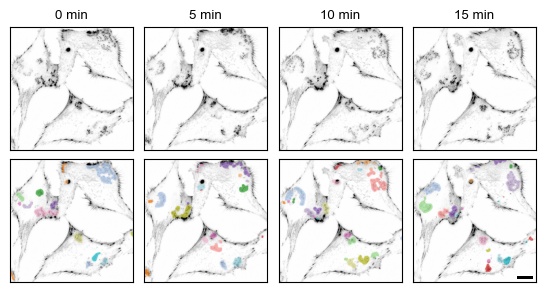

In [33]:
plt.rcParams["svg.fonttype"] = "none"
plt.rc("pdf", fonttype=42)
# set font to arial
plt.rcParams["font.sans-serif"] = "Arial"

fig, ax = plt.subplots(2, 4, figsize=(5.5, 3))

for idx, val in enumerate(samples):
    ax[0, idx].imshow(rbg_lifeact[idx])
    # in minutes
    ax[0, idx].set_title(f"{val*SAMPLE_PERIOD_S/60:.0f} min")
    # remove ticks
    ax[0, idx].set_xticks([])
    ax[0, idx].set_yticks([])

for idx, val in enumerate(samples):
    ax[1, idx].imshow(rgb_events[idx])
    # remove ticks
    ax[1, idx].set_xticks([])
    ax[1, idx].set_yticks([])
    if val == samples[-1]:
        scalebar = ScaleBar(
            PIXEL_SIZE,
            "um",
            length_fraction=0.2,
            location="lower right",
            scale_loc="none",
            box_alpha=0,
            width_fraction=0.025,
        )
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=1)
plt.savefig(os.path.join(DIR_OUT_PLOT, "pannels_insert.pdf"), dpi=600)
# scalebar = 25 um

## Snapshots of an event

In [34]:
viewer = napari.Viewer()
viewer.add_image(actin_corrected[50:-50], name="lifeact", colormap="gray_r")
viewer.add_labels(events_upscaled, name="tracked_waves", colormap=cmap)
viewer.add_labels(events_lineage_upscaled, name="lineages", colormap=cmap)

<Labels layer 'lineages' at 0x2aaa84ca660>

In [35]:
# make crop of single event and follow it over time with high temporal resolution

# get the event id
event_id = 5

# get the frames of the event
event_frames = np.where(events_lineage_upscaled[:50] == event_id)

# get the first frame of the event
first_frame = event_frames[0][0]

# get bounding box of the event
bbox = ndimage.find_objects(events_lineage_upscaled[:50] == event_id)[0]

# crop the event
cropped_event_actin = actin_corrected[50:-50][bbox]
cropped_event = events_upscaled[bbox]

# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
viewer.add_labels(cropped_event, name="tracked_waves", colormap=cmap)

<Labels layer 'tracked_waves' at 0x2aab0c57d40>

In [36]:
# create rgb images of the event
rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked_waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 'eight', 'four', 'glyph00001', 'glyph00002', 'one', 's', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 86]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 23 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', 'eight', 'four', 'glyph00001', 'glyph00002', 'glyph03674', 'glyph03675', 'glyph03676', 'g

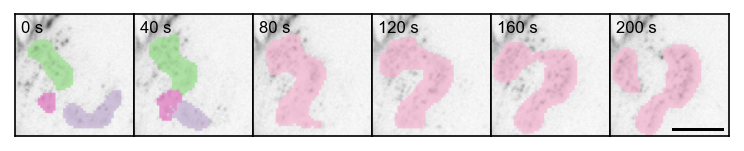

In [37]:
plt.rcParams["svg.fonttype"] = "none"
plt.rc("pdf", fonttype=42)
# set font to arial
plt.rcParams["font.sans-serif"] = "Arial"

fig, ax = plt.subplots(1, 6, figsize=(5, 2), dpi=150)

for idx, val in enumerate(range(first_frame, first_frame + 22, 4)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    ax[idx].text(
        0.05,
        0.95,
        f"{val*SAMPLE_PERIOD_S:.0f} s",
        transform=ax[idx].transAxes,
        fontsize=8,
        verticalalignment="top",
        horizontalalignment="left",
    )
    ax[idx].margins(0, 0)
    if idx == 5:
        scalebar = ScaleBar(
            PIXEL_SIZE / 4,
            "um",
            length_fraction=0.5,
            location="lower right",
            scale_loc="none",
            box_alpha=0,
            width_fraction=0.025,
        )  # 4x upsampled # size is 5 um
        ax[idx].add_artist(scalebar)

plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig(f"{DIR_OUT_PLOT}/event_sequence.pdf", dpi=600)
plt.show()

## Plot a kymograph of all channels

In [ ]:
actin_cropped = actin_corrected[50:-50, 0:200, 340:540]
myosin_cropped = myosin_corrected[50:-50, 0:200, 340:540]
rGBD_cropped = rGBD_corrected[50:-50, 0:200, 340:540]

In [ ]:
## uncomment if you want to draw a new kymograph line

# viewer = napari.Viewer()


# viewer.add_image(actin_cropped, name="actin", colormap="green", blending="translucent", contrast_limits=(50, 800))

# viewer.add_image(myosin_cropped, name="myosin", colormap="magenta", blending="additive", contrast_limits=(150, 350))

# viewer.add_image(rGBD_cropped, name="rGBD", colormap="cyan", blending="additive", contrast_limits=(100, 550))

# viewer.add_shapes([], name="kymo_line")
# line_coords = viewer.layers["kymo_line"].data[0]
# # save the line coordinates to a file
# np.savetxt(os.path.join(DIR_MISC, "line_coords.csv"), line_coords, delimiter=",")  # y, x

In [44]:
line_coords = np.loadtxt(os.path.join(DIR_MISC, "line_coords.csv"), delimiter=",")

In [45]:
from skimage.measure import profile_line

actin_profile = np.array([profile_line(frame, line_coords[1], line_coords[0]) for frame in actin_cropped])
myosin_profile = np.array([profile_line(frame, line_coords[1], line_coords[0]) for frame in myosin_cropped])
rGBD_profile = np.array([profile_line(frame, line_coords[1], line_coords[0]) for frame in rGBD_cropped])

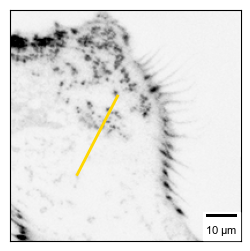

In [46]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(actin_cropped[0], cmap="Grays", vmin=50, vmax=800)
ax.plot(line_coords[:, 1], line_coords[:, 0], "gold", lw=2)
ax.set_xticks([])
ax.set_yticks([])
scale = ScaleBar(PIXEL_SIZE, units="um", location="lower right")
ax.add_artist(scale)
plt.savefig(os.path.join(DIR_OUT_PLOT, "kymo_line.svg"), dpi=300, bbox_inches="tight", pad_inches=0.1)

In [47]:
# draw composite image F-ACTIN and rGBD profiles
viewer = napari.Viewer()
viewer.add_image(actin_profile, name="actin", colormap="green", blending="translucent", contrast_limits=(50, 700))
viewer.add_image(myosin_profile, name="myosin", colormap="magenta", blending="additive", contrast_limits=(250, 325))
viewer.add_image(rGBD_profile, name="rGBD", colormap="cyan", blending="additive", contrast_limits=(190, 290))
composite = render_as_rgb(viewer, None, 1)
viewer.close()

In [48]:
actin_profile_rotated = np.rot90(actin_profile, 1)
rGBD_profile_rotated = np.rot90(rGBD_profile, 1)
myosin_profile_rotated = np.rot90(myosin_profile, 1)
composite_rotated = np.rot90(composite, 1)

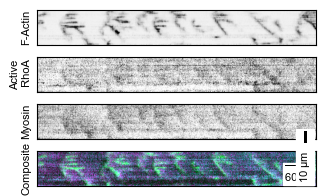

In [49]:
fig, ax = plt.subplots(4, 1, figsize=(5, 2))
ax[0].imshow(actin_profile_rotated, cmap="Grays", vmin=50, vmax=700)
ax[0].set_ylabel("F-Actin")
ax[1].imshow(rGBD_profile_rotated, cmap="Grays", vmin=190, vmax=250)
ax[1].set_ylabel("Active\n RhoA")
ax[2].imshow(myosin_profile_rotated, cmap="Grays", vmin=250, vmax=325)
ax[2].set_ylabel("Myosin")
ax[3].imshow(composite_rotated)
ax[3].set_ylabel("Composite")


for a in ax:
    # remove ticks
    a.set_xticks([])
    a.set_yticks([])

scale = ScaleBar(
    1,
    units="px",
    dimension="pixel-length",
    location="lower right",
    fixed_units="px",
    fixed_value=60,
    rotation="horizontal-only",
)
ax[-1].add_artist(scale)
# ax[-1].autoscale(False)
scale_y = ScaleBar(
    0.366, units="um", location="lower right", fixed_units="um", fixed_value=10, rotation="vertical-only"
)
ax[-1].add_artist(scale_y)
plt.tight_layout()
plt.savefig(os.path.join(DIR_OUT_PLOT, "kymograph.svg"), bbox_inches="tight")

# Validation of Data aggregation and time delay estimation
Here, we shift one reference channel by n frames and compute the time-delay between the unshifted and shifted reference channel. Hence, we can validate the time delay estimation based on the used extraction method.

In [50]:
actin_corrected = io.imread(f"{DIR_OUT_DATA}/actin_corrected.tif")
events_upscaled = io.imread(f"{DIR_OUT_DATA}/tracked_waves.tif")

actin_shifted = actin_corrected[10:]
actin_unshifted = actin_corrected[:-10]

In [51]:
event_ids = np.unique(events_upscaled)[1:]  # Assuming 0 is background

results_list = analyze_events(
    events_upscaled.astype(float),
    np.stack([actin_unshifted, actin_shifted], axis=-1, dtype=float)[50:-50],
    event_ids.astype(float),
    WINDOW_SIZE,
    valid_windows_only=True,
    min_duration=20,
)

In [52]:
df = post_process_results(results_list, "detrended_intensities", filter_window_size=9)
df.head()

channel,event_id,window_frame,frame,middle_frame,intensity_mean-0,intensity_mean-1
0,64,0,0,100,0.347408,0.910790
1,64,0,1,101,0.372664,1.063137
2,64,0,2,102,0.322517,0.917732
3,64,0,3,103,0.411697,1.118405
4,64,0,4,104,0.431021,1.132501


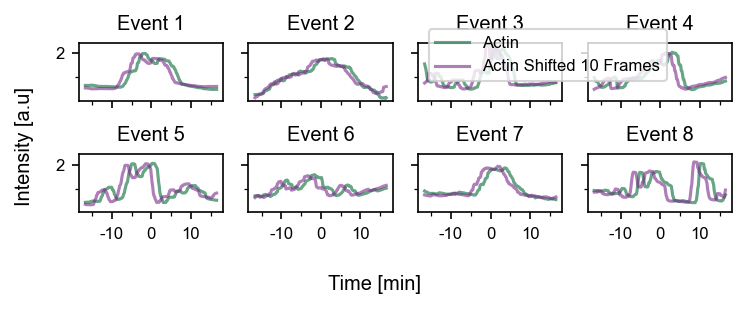

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

names = ["Actin", "Actin Shifted 10 Frames"]
colors = ["#046735", "#7A2989"]

# Sample a random set of rows from the DataFrame
unique_combinations = df["event_id"].drop_duplicates().sample(n=8, random_state=0)

# Create a 2x4 grid of plots
fig, axes = plt.subplots(2, 4, figsize=(5, 2), sharex=True, sharey=True, dpi=150)
axes = axes.flatten()

for i, (ax, row) in enumerate(zip(axes, unique_combinations)):
    # Filter the original DataFrame for the current combination
    grp = df[df["event_id"] == row]
    grp = grp[grp["middle_frame"] == grp["middle_frame"].sample(1, random_state=0).iloc[0]]

    # Convert frames to minutes (already done inline)
    time_in_minutes = (grp["window_frame"] - WINDOW_SIZE) * SAMPLE_PERIOD_S / 60

    # Plot each channel
    ax.plot(time_in_minutes, grp["intensity_mean-0"], color=colors[0], alpha=0.6, label=names[0])
    ax.plot(time_in_minutes, grp["intensity_mean-1"], color=colors[1], alpha=0.6, label=names[1])

    ax.set_title(f"Event: {row}", fontsize=8)

# Apply integer-minute ticks on the shared x-axis
for idx, ax in enumerate(axes):
    ax.set_title(f"Event {idx + 1}")
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.yaxis.set_major_locator(MultipleLocator(4, -2))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.yaxis.set_minor_locator(MultipleLocator(4))


fig.supylabel("Intensity [a.u]")
fig.supxlabel("Time [min]")
fig.legend(labels=names, loc="upper right", bbox_to_anchor=(0.9, 0.92))

plt.tight_layout()
plt.savefig(os.path.join(DIR_OUT_PLOT, "sample_event_shifted_actin.svg"))
plt.show()

Delay of Actin peak relative to Actin: 0.0 min or 0 frames
Delay of Actin Shifted 10 peak relative to Actin: -1.67 min or -10 frames


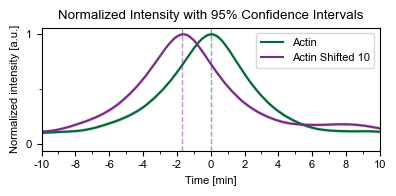

In [ ]:
# Calculate mean, std, and SEM for each frame count
channels = ["intensity_mean-0", "intensity_mean-1"]
df_summary = df.groupby("window_frame")[channels].agg(["mean", "std", "count"]).reset_index()

# Flatten the multi-level columns
df_summary.columns = ["window_frame"] + [f"{col[0]}_{col[1]}" for col in df_summary.columns[1:]]

# Min-max scale the means and calculate 95% CI
for channel in channels:
    mean_col = f"{channel}_mean"
    std_col = f"{channel}_std"
    count_col = f"{channel}_count"

    # Scale the mean to have a min of 0 and max of 1
    min_val = df_summary[mean_col].min()
    max_val = df_summary[mean_col].max()
    df_summary[mean_col] = (df_summary[mean_col] - min_val) / (max_val - min_val)

    # Adjust std (error bars) based on the same scaling
    scale_factor = 1 / (max_val - min_val)
    df_summary[std_col] = df_summary[std_col] * scale_factor

    # Compute SEM and 95% CI
    df_summary[f"{channel}_sem"] = df_summary[std_col] / np.sqrt(df_summary[count_col])
    df_summary[f"{channel}_ci"] = df_summary[f"{channel}_sem"] * 1.96  # 95% CI

# Convert back to long format for plotting
long_df = pd.melt(
    df_summary,
    id_vars="window_frame",
    value_vars=[f"{channel}_mean" for channel in channels],
    var_name="Channel",
    value_name="Mean_intensity",
)

long_df["centered_frames"] = long_df["window_frame"] - WINDOW_SIZE
long_df["time_in_min"] = long_df["centered_frames"] * (SAMPLE_PERIOD_S / 60)
long_df["time_in_min"] = long_df["time_in_min"].round(2)

# Add confidence intervals
long_df["CI"] = pd.melt(
    df_summary, id_vars="window_frame", value_vars=[f"{channel}_ci" for channel in channels], value_name="CI"
)["CI"]

# Map channel names for better readability
channel_mapping = {"intensity_mean-0_mean": "Actin", "intensity_mean-1_mean": "Actin Shifted 10"}
long_df["Channel"] = long_df["Channel"].map(channel_mapping)

# Plotting with confidence intervals
fig, ax = plt.subplots(figsize=(4, 2))

for channel_index, channel in enumerate(long_df["Channel"].unique()):
    subset = long_df[long_df["Channel"] == channel]
    sns.lineplot(
        data=subset,
        x="time_in_min",
        y="Mean_intensity",
        label=channel,
        ax=ax,
        color=colors[channel_index],
        errorbar=None,
    )
    # Confidence intervals
    ax.fill_between(
        subset["time_in_min"],
        subset["Mean_intensity"] - subset["CI"],
        subset["Mean_intensity"] + subset["CI"],
        alpha=0.2,
        color=colors[channel_index],
    )
    # Peak location in time:
    peak_index = subset["Mean_intensity"].argmax()
    peak_time = subset.iloc[peak_index]["time_in_min"]
    peak_frame = subset.iloc[peak_index]["centered_frames"]
    ax.axvline(peak_time, linestyle="--", linewidth=1, color=colors[channel_index], alpha=0.5)
    print(f"Delay of {channel} peak relative to Actin: {peak_time} min or {peak_frame} frames")

# Customize plot appearance
ax.set_title("Normalized Intensity with 95% Confidence Intervals")
ax.set_xlabel("Time [min]")
ax.set_ylabel("Normalized intensity [a.u.]")
ax.set_xlim(-10, 10)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
plt.tight_layout()
plt.savefig(os.path.join(DIR_OUT_PLOT, "normalized_intensity_actin_shifted_10.svg"))
plt.show()